# SKLEARN POWER TRANSFORMER MODULE 
## By Patrick L. Cavins

In this notebook, you will find an introduction to sklearn's power transformer module. This notebook uses the Ames, IA data set. This notebook is meant to accompany a Medium article, [Sklearn's Power Transformer Module](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjHos3Ip73lAhVTKH0KHYF4BM8QFjAAegQIABAG&url=https%3A%2F%2Fmedium.com%2F%40patricklcavins%2Fusing-scipys-powertransformer-3e2b792fd712&usg=AOvVaw1Iu9cCc3G1i1Y4IknM8nVr)

**CONTENTS INCLUDE:**
-  Importing Data with Pandas 
-  Checking for Normality:
    - Visually (Histograms) 
    - Descriptive Statistics (Skew and Kurtosis)
    - D'Angostino's $K^{2}$ Test
- Using the SKLearn Implementation 
- Conclusions 

In [1]:
# The Imports

import pandas as pd 
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.preprocessing import PowerTransformer

## Load the Data and Some Quick EDA

- Using the **Garage Area** feature from the Ames dataset.
- Units, $ft^{2}$
- a single NaN, replaced with 0
- Multiple 0's ~ working under the assumption that a zero indicates that a garage was not present 

In [3]:
#Load the Data
df = pd.read_csv('./train.csv')

#Checking for Nulls / EDA 
nulls = df['Garage Area'].isnull().sum()
print (f'The numbers of nulls: {nulls}')

#Replace the Null with 0 
df['Garage Area'] = df['Garage Area'].replace(np.nan, 0)
nulls = df['Garage Area'].isnull().sum()
print (f'The numbers of nulls: {nulls}')

#Drop Zeros from the pd.series (if zero we can assume that a garage is not around) 
garage_area = df['Garage Area']
print (len(garage_area))
print ('--'*25)
garage_area = garage_area[garage_area != 0]
print (len(garage_area))

The numbers of nulls: 1
The numbers of nulls: 0
2051
--------------------------------------------------
1937


## Checking the Distribution using `Seaborn's Distplot`
Going to create a histogram using `distplot`. I, personally, prefer to keep the kernel density estimate turned off when I am inspecting data visually.  

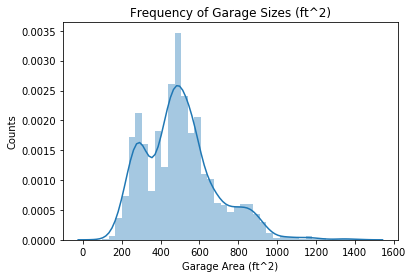

In [4]:
#Plot a Histogram of the data 
ax = sns.distplot(garage_area, kde=True)
ax.set(xlabel= 'Garage Area (ft^2)', ylabel='Counts', title='Frequency of Garage Sizes (ft^2)')
plt.show();

## Kurtosis and Skew in the Distribution 

Before we go and change the distruction using power transformer, it is important to take note of the skewness and the kurtosis in the data. These descriptive statistics would something you might report in any kind of formal report you might provide. 

In [5]:
#Calculating Skew and Kurtosis 
kurtosis = round((stats.kurtosis(garage_area)), ndigits=3)
skew = round((stats.skew(garage_area)), ndigits=3)

#Interpreting Skew 
if -0.5 < skew < 0.5:
    print (f'A skew of {skew} means the distribution is approx. symmetric')
elif  -0.5 < skew < -1.0 or 0.5 < skew < 1.0:
    print (f'A skew of {skew} means the distribution is moderately skewed')
else:
    print (f'A skew of {skew} means the distribution is highly skewed')

#Interpreting Kurtosis
if  -0.5 < kurtosis < 0.5:
    print (f'A kurtosis of {kurtosis} means the distribution is approximately normal sometimes called mesokurtic distributions')
elif kurtosis <= -0.5: 
    print (f'A kurtosis of {kurtosis} means the distribution is light-tailed (negative) sometimes called a platykurtic        distributions')
elif kurtosis >= 0.5:
    print (f'A kurtosis of {kurtosis} means the distribution is heavy-tailed (positive) sometimes called a leptokurtic distribution')

A skew of 0.802 means the distribution is moderately skewed
A kurtosis of 1.034 means the distribution is heavy-tailed (positive) sometimes called a leptokurtic distribution


## Angostino K^2 Test 


In [7]:
#calculate
stat, p = stats.normaltest(garage_area)
print (f'Statistic={stat}, p={p}')
print ('--'*25) 

# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does NOT look Gaussian (reject H0)')

Statistic=204.99777884661893, p=3.057017481546973e-45
--------------------------------------------------
Sample does NOT look Gaussian (reject H0)


## Mathematical Conversion of Garage Area variable 

- The `lambda` variable effects the strength of the transformation we are performing

- We eventually are going to want to optimize the lambda for this specific feature

In [8]:
# Calculating Values in the Box-Cox Transformation
# xt = (x**lambda - 1) / lambda

# define the set of lambda's that we want to search over
lmbda = [0.1, 1.5]

garage_area_xt = []

for i in lmbda: 
    #x = the input data 
    x = garage_area 
    #box-cox transformation 
    transform = (x**i - 1) / i
    #appending the list 
    garage_area_xt.append(transform)

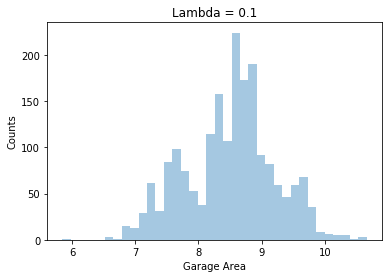

In [9]:
#distplot, lambda = 0.1 
ax = sns.distplot(garage_area_xt[0], kde=False)
ax.set(ylabel = 'Counts', 
       title = 'Lambda = 0.1')
plt.show();

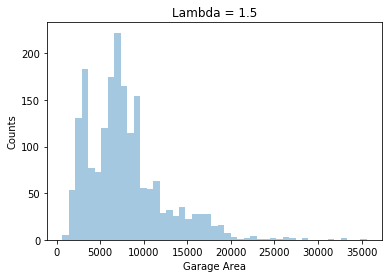

In [10]:
#distplot, lambda = 1.5
ax = sns.distplot(garage_area_xt[1], kde=False)
ax.set(ylabel = 'Counts', title = 'Lambda = 1.5')
plt.show();

## Using Seaborn to Group Box-Cox Transformation's Ouput 

The value of lambda effects the distrubtion so much, we cannot easily visualize  how it effecting the distribution in a single graph

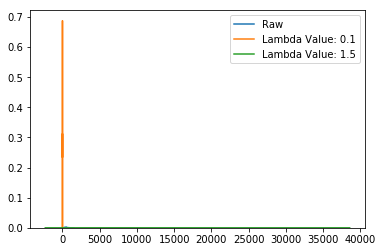

In [11]:
#Plotting the Changes 
sns.kdeplot(garage_area, shade=True, label="Raw")
sns.kdeplot(garage_area_xt[0], shade=True, 
            label= f"Lambda Value: {lmbda[0]}")
sns.kdeplot(garage_area_xt[1], shade=True, 
            label= f'Lambda Value: {lmbda[1]}')

## To See Changes in the Distribution in a Single Graph 

- You will need to use some kind of normalization (ZScore or Min-Max Scaler) 
- ZScore will create unit zero variance, and thus the Yeo-Johnson transformation it required to account for negative numbers

In [12]:
#plot with z-score normalization 
garage_area_zscore = stats.zscore(garage_area)
garage_area_lbmd1  = stats.yeojohnson(garage_area_zscore, lmbda=0.1)
garage_area_lbmd2  = stats.yeojohnson(garage_area_zscore, lmbda=1.5)

#if no lambda is passed, the optimal lambda is found
garage_area_lbmd3, lmbda  = stats.yeojohnson(garage_area_zscore)

print (f'The Optimal Lambda is {lmbda}')

The Optimal Lambda is 0.5855240653016308


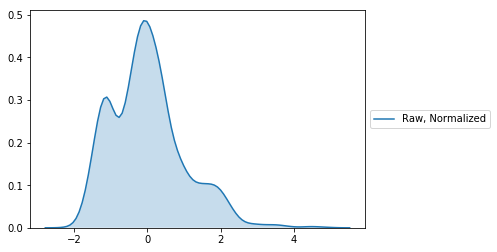

In [11]:
#kdeplot, normalized raw values 
sns.kdeplot(garage_area_zscore,
            shade=True, 
            label="Raw, Normalized")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

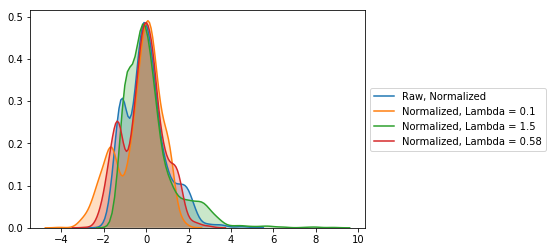

In [13]:
#kdeplot, selected lambda values
sns.kdeplot(garage_area_zscore,
            shade=True, 
            label="Raw, Normalized")
sns.kdeplot(garage_area_lbmd1,
            shade=True,
            label='Normalized, Lambda = 0.1')
sns.kdeplot(garage_area_lbmd2,
            shade=True,
            label='Normalized, Lambda = 1.5')
sns.kdeplot(garage_area_lbmd3,
            shade=True,
            label='Normalized, Lambda = 0.58')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Changes in the Distribution using `distplot` 

- Made some graphs using `distplot` they appeared to be a little too crowded, so I stuck with using the kernel density estimate plots

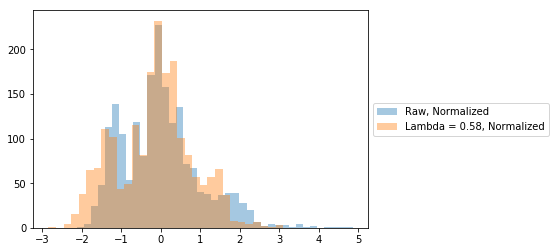

In [13]:
sns.distplot(garage_area_zscore,
             kde=False,
             label='Raw, Normalized')
# sns.distplot(garage_area_lbmd1,
#             kde=False,
#             label='Lambda = 0.1, Noramlized')
# sns.distplot(garage_area_lbmd2,
#              kde=False,
#              label='Lambda = 1.0, Normalized')
sns.distplot(garage_area_lbmd3,
             kde=False,
             label='Lambda = 0.58, Normalized')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Implementing Sklearn's Implementation

### `Parameters `

**method** : str, (default=’yeo-johnson’)

**standardize** : boolean, default=True
Set to True to apply zero-mean, unit-variance normalization to the transformed output.

### `Attributes`

**lambdas_**: array of float, shape (n_features,)
The parameters of the power transformation for the selected features.

## Data Cleaning and EDA

Use a boolean filter to remove the garage areas equal to zero.

In [14]:
df_v1 = df.loc[(df['Garage Area'] != 0)]

features = df[['Garage Area', 'Lot Area']]

print (df.shape)
print (df_v1.shape)


(2051, 81)
(1937, 81)


## Using the PowerTransformer Module

In [16]:
#instatiate 
pt = PowerTransformer(method='yeo-johnson', standardize=True) 

#Fit the data to the powertransformer
skl_yeojohnson = pt.fit(features)

#Lets get the Lambdas that were found
print (skl_yeojohnson.lambdas_)

calc_lambdas = skl_yeojohnson.lambdas_

#Transform the data 
skl_yeojohnson = pt.transform(features)

#Pass the transformed data into a new dataframe 
df_xt = pd.DataFrame(data=skl_yeojohnson, columns=['Garage Area', 'Lot Area'])

df_xt.head()

[0.80353634 0.15891886]


,Garage Area,Lot Area
0,0.062994,0.835048
1,0.427338,0.489251
2,-1.007080,-0.270492
3,-0.273147,0.158889
4,0.102602,0.947211


## Kde Plot 

- You can stack the variables into a single plot 

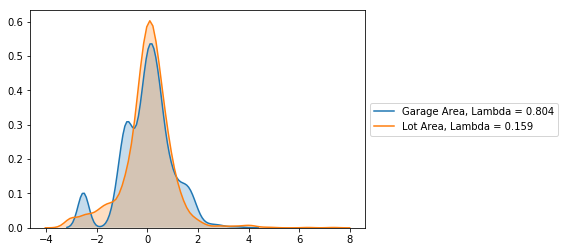

In [116]:
sns.kdeplot(df_xt['Garage Area'], 
            shade=True,
            label=f'Garage Area, Lambda = {round(calc_lambdas[0], ndigits=3)}')

sns.kdeplot(df_xt['Lot Area'], 
            shade=True,
            label=f'Lot Area, Lambda = {round(calc_lambdas[1], ndigits=3)}')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [17]:
#calculate normaltest using tranformed data
stat, p = stats.normaltest(df_xt['Garage Area'])
print (f'Statistic={stat}, p={p}')
print ('--'*25) 

# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does NOT look Gaussian (reject H0)')

Statistic=74.56827003039477, p=6.422526433134362e-17
--------------------------------------------------
Sample does NOT look Gaussian (reject H0)
